<a href="https://colab.research.google.com/github/den1shh/summer-school-qml/blob/main/qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane qiskit pennylane-qiskit ply mitiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.4/171.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import mitiq
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
input_dim = 16
num_qubits = 4
reduced_dim = num_qubits
repeats1 = 2
repeats2 = 2
learning_rate = 0.3
epochs = 60


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
[ds] = qml.data.load("other", name="bars-and-stripes")

train_features = (np.sign(np.array(ds.train['4']['inputs']))+1)/2
train_labels =(np.array(ds.train['4']['labels']) + 1) / 2
test_features = (np.sign(np.array(ds.test['4']['inputs']))+1)/2
test_labels =(np.array(ds.test['4']['labels']) + 1) / 2

In [7]:
class BaSDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = torch.tensor(data_x).float()
        self.y = torch.tensor(data_y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [8]:
train_dataset = BaSDataset(train_features, train_labels)
test_dataset = BaSDataset(test_features, test_labels)

In [9]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Noiseless simulator

In [10]:
dev = qml.device("default.qubit.torch", wires=range(num_qubits), torch_device=device)

In [11]:
# @title QDI layer

def qdi_subroutine_1(params, wires):
    for i in range(len(wires)):
        qml.RX(params[i], wires=wires[i])
    for j in range(len(wires)-1):
        qml.ECR(wires=[wires[j], wires[j+1]])
    qml.ECR(wires=[wires[len(wires)-1], wires[0]])
    qml.Barrier()

def qdi_subroutine_2(params, wires):
    for i in range(len(wires)):
        qml.RX(params[i], wires=wires[i])
    for j in range(len(wires)-1):
        qml.ECR(wires=[wires[j], wires[j+1]])
    qml.ECR(wires=[wires[len(wires)-1], wires[0]])
    qml.Barrier()

def qdi_subroutine_3(wires):
    for i in range(1, len(wires)):
        qml.ECR(wires=[wires[i], wires[0]])
    qml.Barrier()

@qml.qnode(dev, interface='torch', diff_method="backprop")
def qdi_circuit(weights, input_array):
    qml.layer(qdi_subroutine_1, repeats1, weights[:repeats1 * num_qubits].reshape(repeats1, num_qubits), wires=range(num_qubits))
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    qml.layer(qdi_subroutine_2, repeats2, weights[repeats1 * num_qubits:].reshape(repeats2, num_qubits), wires=range(num_qubits))
    qml.layer(qdi_subroutine_3, 1, wires=range(num_qubits))
    return qml.expval(qml.PauliY(0))

In [12]:
print(qml.draw(qdi_circuit)(np.ones(((repeats1 + repeats2) * num_qubits,)), np.ones(num_qubits)))

0: ──RX(1.00)─╭ECR───────────╭ECR──||──RX(1.00)─╭ECR───────────╭ECR──||─╭AngleEmbedding(M0)
1: ──RX(1.00)─╰ECR─╭ECR──────│─────||──RX(1.00)─╰ECR─╭ECR──────│─────||─├AngleEmbedding(M0)
2: ──RX(1.00)──────╰ECR─╭ECR─│─────||──RX(1.00)──────╰ECR─╭ECR─│─────||─├AngleEmbedding(M0)
3: ──RX(1.00)───────────╰ECR─╰ECR──||──RX(1.00)───────────╰ECR─╰ECR──||─╰AngleEmbedding(M0)

───RX(1.00)─╭ECR───────────╭ECR──||──RX(1.00)─╭ECR───────────╭ECR──||─╭ECR─╭ECR─╭ECR──||─┤  <Y>
───RX(1.00)─╰ECR─╭ECR──────│─────||──RX(1.00)─╰ECR─╭ECR──────│─────||─╰ECR─│────│─────||─┤     
───RX(1.00)──────╰ECR─╭ECR─│─────||──RX(1.00)──────╰ECR─╭ECR─│─────||──────╰ECR─│─────||─┤     
───RX(1.00)───────────╰ECR─╰ECR──||──RX(1.00)───────────╰ECR─╰ECR──||───────────╰ECR──||─┤     

M0 = 
[1. 1. 1. 1.]


In [13]:
# @title EFQ layer
def efq_subroutine_1(params, wires):
    j = 0
    for i in range(len(wires)):
        qml.RY(params[i+j], wires=i)
        qml.RZ(params[i+j+1], wires=i)
        qml.RX(params[i+j+2], wires=i)
        j += 2

    for i in range(len(wires)):
        qml.ECR(wires=[i, (i + 1) % len(wires)])

    j = 0
    for i in range(len(wires)):
        qml.RY(params[3*len(wires)+i+j], wires=i)
        qml.RZ(params[3*len(wires)+i+j+1], wires=i)
        qml.RX(params[3*len(wires)+i+j+2], wires=i)
        j += 2

def efq_subroutine_2(input_array, wires):
    for i in range(len(wires)):
        qml.AngleEmbedding(2**i*input_array[i].reshape((1,)), wires=[i], rotation='Z')

def efq_subroutine_3(params, wires):
    j = 0
    for i in range(len(wires)):
        qml.RY(params[6*len(wires)+i+j], wires=i)
        qml.RZ(params[6*len(wires)+i+j+1], wires=i)
        qml.RX(params[6*len(wires)+i+j+2], wires=i)
        j += 2

    for i in range(len(wires)):
        qml.ECR(wires=[i, (i + 1) % len(wires)])

    j = 0
    for i in range(len(wires)):
        qml.RY(params[9*len(wires)+i+j], wires=i)
        qml.RZ(params[9*len(wires)+i+j+1], wires=i)
        qml.RX(params[9*len(wires)+i+j+2], wires=i)
        j += 2

def efq_subroutine_4(wires):
    for i in range(len(wires)-1, 0, -1):
        qml.ECR(wires=[i, 0])

@qml.qnode(dev, interface="torch", diff_method="backprop")
def efq_circuit(weights, input_array):
    qml.layer(efq_subroutine_1, 1, weights.reshape((1, 12*num_qubits)), wires=range(num_qubits))
    qml.Barrier()
    qml.layer(efq_subroutine_2, 1, input_array = input_array, wires=range(num_qubits))
    qml.Barrier()
    qml.layer(efq_subroutine_3, 1, weights.reshape((1, 12*num_qubits)), wires=range(num_qubits))
    qml.layer(efq_subroutine_4, 1, wires=range(num_qubits))
    return qml.expval(qml.PauliZ(0))

In [14]:
print(qml.draw(efq_circuit)(torch.ones((12*num_qubits,)), torch.ones(num_qubits)))

0: ──RY(1.00)──RZ(1.00)──RX(1.00)─╭ECR───────────╭ECR──RY(1.00)──RZ(1.00)──RX(1.00)──||
1: ──RY(1.00)──RZ(1.00)──RX(1.00)─╰ECR─╭ECR──────│─────RY(1.00)──RZ(1.00)──RX(1.00)──||
2: ──RY(1.00)──RZ(1.00)──RX(1.00)──────╰ECR─╭ECR─│─────RY(1.00)──RZ(1.00)──RX(1.00)──||
3: ──RY(1.00)──RZ(1.00)──RX(1.00)───────────╰ECR─╰ECR──RY(1.00)──RZ(1.00)──RX(1.00)──||

───AngleEmbedding(M0)──||──RY(1.00)──RZ(1.00)──RX(1.00)─╭ECR───────────╭ECR──RY(1.00)──RZ(1.00)
───AngleEmbedding(M1)──||──RY(1.00)──RZ(1.00)──RX(1.00)─╰ECR─╭ECR──────│─────RY(1.00)──RZ(1.00)
───AngleEmbedding(M2)──||──RY(1.00)──RZ(1.00)──RX(1.00)──────╰ECR─╭ECR─│─────RY(1.00)──RZ(1.00)
───AngleEmbedding(M3)──||──RY(1.00)──RZ(1.00)──RX(1.00)───────────╰ECR─╰ECR──RY(1.00)──RZ(1.00)

───RX(1.00)─╭ECR─╭ECR─╭ECR─┤  <Z>
───RX(1.00)─│────│────╰ECR─┤     
───RX(1.00)─│────╰ECR──────┤     
───RX(1.00)─╰ECR───────────┤     

M0 = 
tensor([1.])
M1 = 
tensor([2.])
M2 = 
tensor([4.])
M3 = 
tensor([8.])


In [15]:
# @title PQN QDI QDI layer
@qml.qnode(dev, interface='torch', diff_method="backprop")
def pqn_circuit(weights, input_array):
    qml.layer(qdi_subroutine_1, repeats1, weights[:repeats1 * num_qubits//2].reshape(repeats1, num_qubits//2), wires=[0,1])
    qml.layer(qdi_subroutine_1, repeats1, weights[(repeats1+repeats2)*num_qubits//2:(2*repeats1+repeats2) * num_qubits//2].reshape(repeats1, num_qubits//2), wires=[2,3])
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    qml.layer(qdi_subroutine_2, repeats2, weights[repeats1 * num_qubits//2:(repeats1+repeats2)*num_qubits//2].reshape(repeats2, num_qubits//2), wires=[0,1])
    qml.layer(qdi_subroutine_2, repeats2, weights[(2*repeats1+repeats2) * num_qubits//2:].reshape(repeats2, num_qubits//2), wires=[2,3])
    qml.layer(qdi_subroutine_3, 1, wires=[0, 1])
    qml.layer(qdi_subroutine_3, 1, wires=[2, 3])


    return [qml.expval(qml.PauliY(w)) for w in [0, 2]]

In [16]:
print(qml.draw(pqn_circuit)(np.ones(((repeats1 + repeats2) * num_qubits,)), np.ones(num_qubits)))

0: ──RX(1.00)─╭ECR─╭ECR──||──RX(1.00)─╭ECR─╭ECR──||──────────────────────||──────────────────────||
1: ──RX(1.00)─╰ECR─╰ECR──||──RX(1.00)─╰ECR─╰ECR──||──────────────────────||──────────────────────||
2: ──────────────────────||──────────────────────||──RX(1.00)─╭ECR─╭ECR──||──RX(1.00)─╭ECR─╭ECR──||
3: ──────────────────────||──────────────────────||──RX(1.00)─╰ECR─╰ECR──||──RX(1.00)─╰ECR─╰ECR──||

──╭AngleEmbedding(M0)──RX(1.00)─╭ECR─╭ECR──||──RX(1.00)─╭ECR─╭ECR──||──────────────────────||
──├AngleEmbedding(M0)──RX(1.00)─╰ECR─╰ECR──||──RX(1.00)─╰ECR─╰ECR──||──────────────────────||
──├AngleEmbedding(M0)──────────────────────||──────────────────────||──RX(1.00)─╭ECR─╭ECR──||
──╰AngleEmbedding(M0)──────────────────────||──────────────────────||──RX(1.00)─╰ECR─╰ECR──||

───────────────────────||─╭ECR──||───────||─┤  <Y>
───────────────────────||─╰ECR──||───────||─┤     
───RX(1.00)─╭ECR─╭ECR──||───────||─╭ECR──||─┤  <Y>
───RX(1.00)─╰ECR─╰ECR──||───────||─╰ECR──||─┤     

M0 = 
[1. 1. 1. 1

In [17]:
class QDIHybridModel(nn.Module):
    def __init__(self):
        super(QDIHybridModel, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [18]:
class EFQHybridModel(nn.Module):
    def __init__(self):
        super(EFQHybridModel, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn(12*num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = efq_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [19]:
class PQNHybridModel(nn.Module):
    def __init__(self):
        super(PQNHybridModel, self).__init__()
        self.classical_layer_1 = nn.Linear(input_dim, reduced_dim)
        self.classical_layer_2 = nn.Linear(reduced_dim//2, 1)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer_1(x))
        q_out = torch.zeros((x.size(0), 2), device=device)
        for i in range(x.size(0)):
            q_out[i] = torch.tensor(pqn_circuit(self.q_params, x[i]), device = device)
        output = self.classical_layer_2(q_out)
        return torch.sigmoid(output).squeeze(1)

In [20]:
criterion = nn.BCELoss()

In [21]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)

    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_accuracy = 0

        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            preds = model(X)

            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().cpu().numpy()

        train_loss /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                preds = model(X)
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()

        test_accuracy /= len(test_dataloader)

        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_accuracy_arr

In [22]:
QDI_model = QDIHybridModel().to(device)
optimizer_for_qdi = optim.Adam(QDI_model.parameters(), lr=learning_rate)

In [23]:
EFQ_model = EFQHybridModel().to(device)
optimizer_for_efq = optim.Adam(EFQ_model.parameters(), lr=learning_rate)

In [24]:
PQN_model = PQNHybridModel().to(device)
optimizer_for_pqn = optim.Adam(PQN_model.parameters(), lr=learning_rate)

In [25]:
QDI_losses, \
    QDI_accuracies = train(QDI_model, criterion=criterion,
                              optimizer=optimizer_for_qdi,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]

In [26]:
EFQ_losses, \
    EFQ_accuracies = train(EFQ_model, criterion=criterion,
                              optimizer=optimizer_for_efq,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]

In [27]:
PQN_losses, \
    PQN_accuracies = train(PQN_model, criterion=criterion,
                              optimizer=optimizer_for_pqn,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]

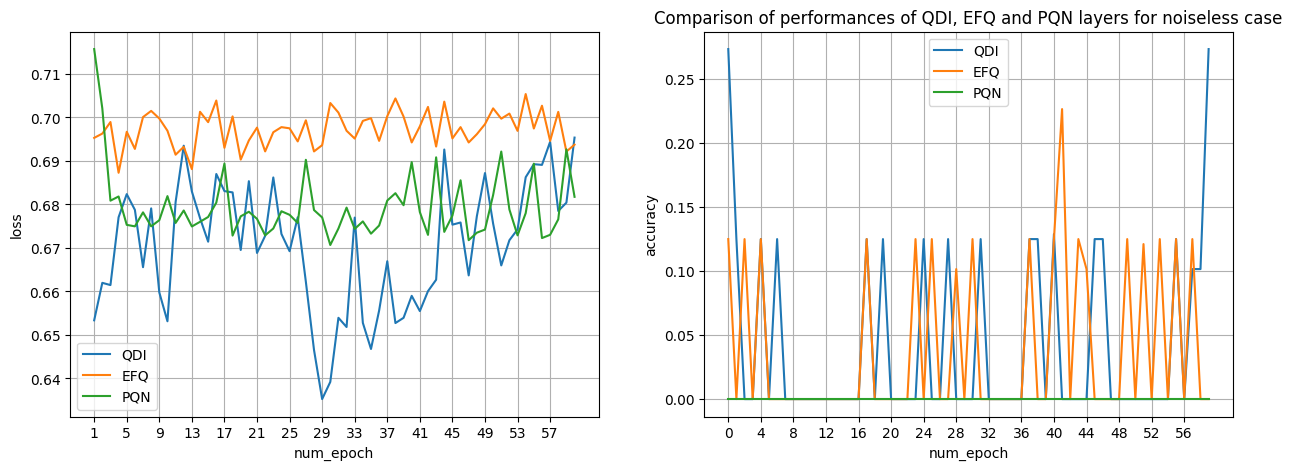

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
# ax.set_title('Comparison of QDI, EFQ and PQN performances for noiseless case')

ax[0].plot(np.arange(1, QDI_losses.shape[0] + 1), QDI_losses, label='QDI')
ax[0].plot(np.arange(1, EFQ_losses.shape[0] + 1), EFQ_losses, label='EFQ')
ax[0].plot(np.arange(1, PQN_losses.shape[0] + 1), PQN_losses, label='PQN')
ax[0].set_xticks(np.arange(1, QDI_losses.shape[0] + 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(QDI_accuracies.shape[0]), QDI_accuracies,
           label='QDI')
ax[1].plot(np.arange(EFQ_accuracies.shape[0]), EFQ_accuracies,
           label='EFQ')
ax[1].plot(np.arange(PQN_accuracies.shape[0]), PQN_accuracies,
           label='PQN')
ax[1].set_xticks(np.arange(0, PQN_accuracies.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Comparison of performances of QDI, EFQ and PQN layers for noiseless case')
plt.show()

# Simulator with noise model specific to IBM Sherbrooke

In [ ]:
from qiskit_aer import noise
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

IBMProvider.save_account(token='my token',
                         overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
noise_model = NoiseModel.from_backend(backend)
dev = qml.device('qiskit.aer', wires=range(num_qubits), noise_model=noise_model)

In [ ]:
@qml.qnode(dev, interface='torch')
def qdi_circuit(weights, input_array):
    qml.layer(qdi_subroutine_1, repeats1, weights[:repeats1 * num_qubits].reshape(repeats1, num_qubits), wires=range(num_qubits))
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    qml.layer(qdi_subroutine_2, repeats2, weights[repeats1 * num_qubits:].reshape(repeats2, num_qubits), wires=range(num_qubits))
    qml.layer(qdi_subroutine_3, 1, wires=range(num_qubits))
    return qml.expval(qml.PauliY(0))
@qml.qnode(dev, interface="torch")
def efq_circuit(weights, input_array):
    qml.layer(efq_subroutine_1, 1, weights.reshape((1, 12*num_qubits)), wires=range(num_qubits))
    qml.Barrier()
    qml.layer(efq_subroutine_2, 1, input_array = input_array, wires=range(num_qubits))
    qml.Barrier()
    qml.layer(efq_subroutine_3, 1, weights.reshape((1, 12*num_qubits)), wires=range(num_qubits))
    qml.layer(efq_subroutine_4, 1, wires=range(num_qubits))
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev, interface='torch')
def pqn_circuit(weights, input_array):
    qml.layer(qdi_subroutine_1, repeats1, weights[:repeats1 * num_qubits//2].reshape(repeats1, num_qubits//2), wires=[0,1])
    qml.layer(qdi_subroutine_1, repeats1, weights[(repeats1+repeats2)*num_qubits//2:(2*repeats1+repeats2) * num_qubits//2].reshape(repeats1, num_qubits//2), wires=[2,3])
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    qml.layer(qdi_subroutine_2, repeats2, weights[repeats1 * num_qubits//2:(repeats1+repeats2)*num_qubits//2].reshape(repeats2, num_qubits//2), wires=[0,1])
    qml.layer(qdi_subroutine_2, repeats2, weights[(2*repeats1+repeats2) * num_qubits//2:].reshape(repeats2, num_qubits//2), wires=[2,3])
    qml.layer(qdi_subroutine_3, 1, wires=[0, 1])
    qml.layer(qdi_subroutine_3, 1, wires=[2, 3])
    return [qml.expval(qml.PauliY(w)) for w in [0, 2]]

In [ ]:
class QDIHybridModel_nsy(nn.Module):
    def __init__(self):
        super(QDIHybridModel_nsy, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
class EFQHybridModel_nsy(nn.Module):
    def __init__(self):
        super(EFQHybridModel_nsy, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn(12*num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = efq_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
class PQNHybridModel_nsy(nn.Module):
    def __init__(self):
        super(PQNHybridModel_nsy, self).__init__()
        self.classical_layer_1 = nn.Linear(input_dim, reduced_dim)
        self.classical_layer_2 = nn.Linear(reduced_dim//2, 1)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer_1(x))
        q_out = torch.zeros((x.size(0), 2), device=device)
        for i in range(x.size(0)):
            q_out[i] = torch.tensor(pqn_circuit(self.q_params, x[i]), device = device)
        output = self.classical_layer_2(q_out)
        return torch.sigmoid(output).squeeze(1)

In [ ]:
criterion = nn.BCELoss()


In [ ]:
QDI_model_nsy = QDIHybridModel_nsy().to(device)
optimizer_for_nsy_qdi = optim.Adam(QDI_model_nsy.parameters(), lr=learning_rate)

In [ ]:
EFQ_model_nsy = EFQHybridModel_nsy().to(device)
optimizer_for_nsy_efq = optim.Adam(EFQ_model_nsy.parameters(), lr=learning_rate)

In [ ]:
PQN_model_nsy = PQNHybridModel_nsy().to(device)
optimizer_for_nsy_pqn = optim.Adam(PQN_model_nsy.parameters(), lr=learning_rate)

In [ ]:
QDI_losses_nsy, \
    QDI_accuracies_nsy = train(QDI_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_qdi,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
EFQ_losses_nsy, \
    EFQ_accuracies_nsy = train(EFQ_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_efq,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
PQN_losses_nsy, \
    PQN_accuracies_nsy = train(PQN_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_pqn,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(1, QDI_losses_nsy.shape[0] + 1), QDI_losses_nsy, label='QDI')
ax[0].plot(np.arange(1, EFQ_losses_nsy.shape[0] + 1), EFQ_losses_nsy, label='EFQ')
ax[0].plot(np.arange(1, PQN_losses_nsy.shape[0] + 1), PQN_losses_nsy, label='PQN')
ax[0].set_xticks(np.arange(1, QDI_losses_nsy.shape[0]+ 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(QDI_accuracies_nsy.shape[0]), QDI_accuracies_nsy,
           label='QDI')
ax[1].plot(np.arange(EFQ_accuracies_nsy.shape[0]), EFQ_accuracies_nsy,
           label='EFQ')
ax[1].plot(np.arange(PQN_accuracies_nsy.shape[0]), PQN_accuracies_nsy,
           label='PQN')
ax[1].set_xticks(np.arange(0, PQN_accuracies_nsy.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Comparison of performances of QDI, EFQ and PQN layers for noisy case')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (15, 5))

ax[0, 0].plot(np.arange(1, QDI_losses.shape[0] + 1), QDI_losses, label='QDI, noiseless case')
ax[0, 0].plot(np.arange(1, QDI_losses_nsy.shape[0] + 1), QDI_losses_nsy, label='QDI, noisy case')
ax[0, 0].set_xticks(np.arange(1, QDI_losses_nsy.shape[0] + 1, 4))
ax[0, 0].set_xlabel('num_epoch')
ax[0, 0].set_ylabel('loss')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(np.arange(1, EFQ_losses.shape[0] + 1), EFQ_losses, label='EFQ, noiseless case')
ax[0, 1].plot(np.arange(1, EFQ_losses_nsy.shape[0] + 1), EFQ_losses_nsy, label='EFQ, noisy case')
ax[0, 1].set_xticks(np.arange(1, EFQ_losses_nsy.shape[0] + 1, 4))
ax[0, 1].set_xlabel('num_epoch')
ax[0, 1].set_ylabel('loss')
ax[0, 1].legend()
ax[0, 1].grid()

ax[0, 2].plot(np.arange(1, PQN_losses.shape[0] + 1), PQN_losses, label='PQN, noiseless case')
ax[0, 2].plot(np.arange(1, PQN_losses_nsy.shape[0] + 1), PQN_losses_nsy, label='PQN, noisy case')
ax[0, 2].set_xticks(np.arange(1, PQN_losses_nsy.shape[0]+ 1, 4))
ax[0, 2].set_xlabel('num_epoch')
ax[0, 2].set_ylabel('loss')
ax[0, 2].legend()
ax[0, 2].grid()

ax[1, 0].plot(np.arange(QDI_accuracies.shape[0]), QDI_accuracies, label='QDI, noiseless case')
ax[1, 0].plot(np.arange(QDI_accuracies_nsy.shape[0]), QDI_accuracies_nsy, label='QDI, noisy case')
ax[1, 0].set_xticks(np.arange(0, QDI_accuracies_nsy.shape[0], 4))
ax[1, 0].set_xlabel('num_epoch')
ax[1, 0].set_ylabel('accuracy')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(np.arange(EFQ_accuracies.shape[0]), EFQ_accuracies, label='EFQ, noiseless case')
ax[1, 1].plot(np.arange((EFQ_accuracies_nsy)), EFQ_accuracies_nsy, label='EFQ, noisy case')
ax[1, 1].set_xticks(np.arange(0, EFQ_accuracies_nsy.shape[0], 4))
ax[1, 1].set_xlabel('num_epoch')
ax[1, 1].set_ylabel('accuracy')
ax[1, 1].legend()
ax[1, 1].grid()

ax[1, 2].plot(np.arange(PQN_accuracies.shape[0]), PQN_accuracies, label='PQN, noiseless case')
ax[1, 2].plot(np.arange(PQN_accuracies_nsy.shape[0]), PQN_accuracies_nsy, label='PQN, noisy case')
ax[1, 2].set_xticks(np.arange(0, PQN_accuracies_nsy.shape[0], 4))
ax[1, 2].set_xlabel('num_epoch')
ax[1, 2].set_ylabel('accuracy')
ax[1, 2].legend()
ax[1, 2].grid()
plt.title("Comparison performances of layers for noiseless and noisy cases")

plt.show()

# Forward pass with the IBM Sherbrooke device

In [ ]:
dev = qml.device("qiskit.ibmq", wires=range(num_qubits), backend=backend)

In [ ]:
@qml.qnode(dev, interface='torch')
def qdi_circuit_for_ibmq(weights, input_array):
    qml.layer(qdi_subroutine_1, repeats1, weights[:repeats1 * num_qubits].reshape(repeats1, num_qubits), wires=range(num_qubits))
    qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
    qml.layer(qdi_subroutine_2, repeats2, weights[repeats1 * num_qubits:].reshape(repeats2, num_qubits), wires=range(num_qubits))
    qml.layer(qdi_subroutine_3, 1, wires=range(num_qubits))
    return qml.expval(qml.PauliY(0))

In [ ]:
class QDIHybridModel_ibmq_unmitigated(nn.Module):
    def __init__(self):
        super(QDIHybridModel_ibmq_unmitigated, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit_for_ibmq(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
QDI_model_ibmq = QDIHybridModel_ibmq_unmitigated().to(device)

In [ ]:
QDI_model_ibmq.load_state_dict(QDI_model.state_dict())

In [ ]:
unmitigated_accuracy = 0

QDI_model_ibmq.eval()
for batch in test_dataloader:
    X = batch[0].to(device)
    y = batch[1].to(device)

    with torch.no_grad():
        preds = QDI_model_ibmq(X)
        unmitigated_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()

unmitigated_accuracy /= len(test_dataloader)
print(f"Unmitigated accuracy {unmitigated_accuracy:.3f}")

In [ ]:
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory

scale_factors = [1, 2, 3]
noise_scale_method = fold_global

mitigated_qdi_circuit = qml.transforms.mitigate_with_zne(
    qdi_circuit_for_ibmq,
    scale_factors,
    noise_scale_method,
    RichardsonFactory.extrapolate,
)

In [ ]:
class QDIHybridModel_ibmq_mitigated(nn.Module):
    def __init__(self):
        super(QDIHybridModel_ibmq_mitigated, self).__init__()
        self.classical_layer = nn.Linear(input_dim, reduced_dim)
        self.q_params = nn.Parameter(torch.randn((repeats1 + repeats2) * num_qubits))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = mitigated_qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
QDI_model_ibmq = QDIHybridModel_ibmq_mitigated().to(device)

In [ ]:
QDI_model_ibmq.load_state_dict(QDI_model.state_dict())

In [ ]:
mitigated_accuracy = 0

QDI_model_ibmq.eval()
for batch in test_dataloader:
    X = batch[0].to(device)
    y = batch[1].to(device)

    with torch.no_grad():
        preds = QDI_model_ibmq(X)
        mitigated_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()

mitigated_accuracy /= len(test_dataloader)
print(f"Mitigated accuracy {mitigated_accuracy:.3f}")

In [ ]:
print(f"Unmitigated accuracy {unmitigated_accuracy:.3f}")
print(f"Mitigated accuracy {mitigated_accuracy:.3f}")